#### Imports des librairies

In [55]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM # type: ignore
from tensorflow.keras import layers # type: ignore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.losses import Huber # type: ignore

#### Récupération et initialisation des données

In [56]:
data = pd.read_csv("../myhadoop/data.csv")
# On spécifie les features qui nous intéressent
data = data.loc[:,['Timestamp','Open','High','Low','Close','Volume']]
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s')

In [57]:
# data.head(10)
# data.tail(10)
data.count()

Timestamp    6695280
Open         6695281
High         6695281
Low          6695281
Close        6695281
Volume       6695281
Date         6695280
dtype: int64

In [58]:
# On définit la date comme index car c'est une série temporelle
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)

DatetimeIndex(['2012-01-01 10:01:00', '2012-01-01 10:02:00',
               '2012-01-01 10:03:00', '2012-01-01 10:04:00',
               '2012-01-01 10:05:00', '2012-01-01 10:06:00',
               '2012-01-01 10:07:00', '2012-01-01 10:08:00',
               '2012-01-01 10:09:00', '2012-01-01 10:10:00',
               ...
               '2024-10-08 23:52:00', '2024-10-08 23:53:00',
               '2024-10-08 23:54:00', '2024-10-08 23:55:00',
               '2024-10-08 23:56:00', '2024-10-08 23:57:00',
               '2024-10-08 23:58:00', '2024-10-08 23:59:00',
               '2024-10-09 00:00:00',                 'NaT'],
              dtype='datetime64[ns]', name='Date', length=6695281, freq=None)


In [59]:
# Avant 2017, aucune valeur n'est vraiment significative. 6.6M de lignes le csv on le fait maigrir un peu.
data = data[data.index >= '2017-01-01']
data = data[data['Volume'] > 0]
data = data.dropna()
# On se base sur le prix de clôture car c'est le prix final de la journée | on peut aussi utiliser le prix d'ouverture
data = data[np.isfinite(data['Close'])]
aim = 'Close'

In [60]:
# On split les données en train et test avec 80% des données pour le train et 20% pour le test
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# On affiche la répartition des données
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('BITCOIN', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

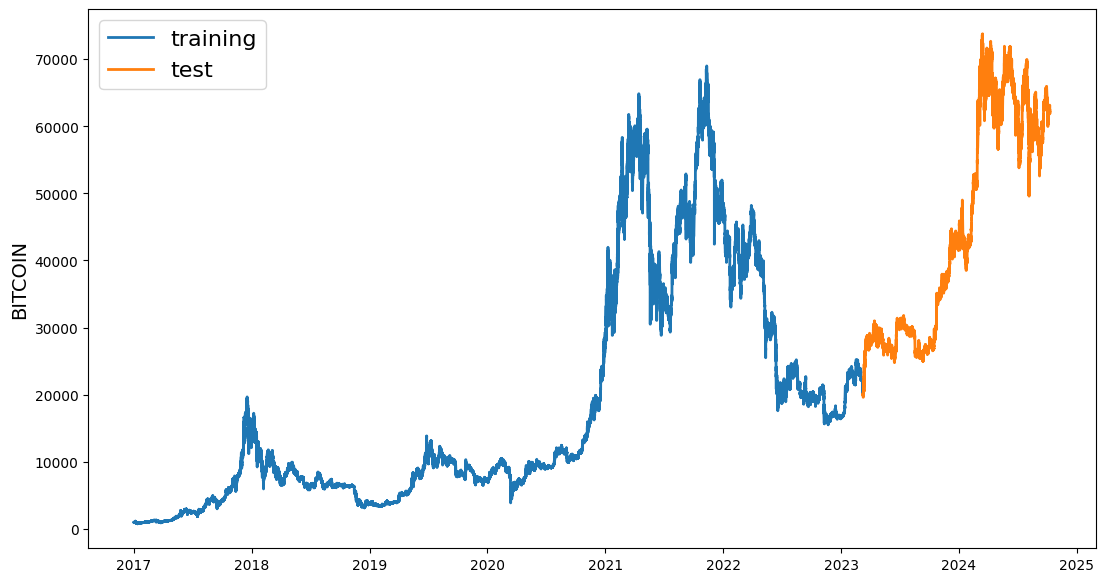

In [61]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [62]:
# On ajuste les données afin qu'elles commencent à 0
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

# On redimensionne les données pour qu'elles soient comprises entre 0 et 1
def normalise_min_max(continuous):
    data_range = continuous.max() - continuous.min()
    if data_range == 0:
        return continuous - continuous.min()
    else:
        return (continuous - continuous.min()) / data_range

In [63]:
# Création de fenêtres glissantes pour capturer les tendances
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

# Division des données en train et test
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [64]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    # On spécifie le nombre de neurones et la forme d'entrée
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    # On choisie une couche Dropout pour réduire. À tester entre 0.2 et 0.5 mais au dessus de 0.5 c'est trop et en dessous c'est décalé
    model.add(Dropout(dropout))
    # On ajoute une couche dense pour spécifier combien d'informations on veut en sortie
    model.add(Dense(units=output_size))
    # On applique une fonction d'activation pour normaliser les valeurs de sortie
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 10
batch_size = 32
loss = Huber()
dropout = 0.24
optimizer = 'adam'

train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [65]:
print("X_train contains NaN:", np.isnan(X_train).any())
print("X_train contains Inf:", np.isinf(X_train).any())
print("y_train contains NaN:", np.isnan(y_train).any())
print("y_train contains Inf:", np.isinf(y_train).any())

X_train contains NaN: False
X_train contains Inf: False
y_train contains NaN: False
y_train contains Inf: False


In [66]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)

c:\wamp64\www\IPSSI\MIA 2\BigData\TpGroupe\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 222s 2ms/step - loss: 1.2991e-04 - val_loss: 5.0942e-07
Epoch 2/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 224s 2ms/step - loss: 1.6901e-06 - val_loss: 4.9957e-07
Epoch 3/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 226s 2ms/step - loss: 1.6169e-06 - val_loss: 4.8629e-07
Epoch 4/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 227s 2ms/step - loss: 1.6005e-06 - val_loss: 4.8506e-07
Epoch 5/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 242s 2ms/step - loss: 1.5819e-06 - val_loss: 4.3696e-07
Epoch 6/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 191s 2ms/step - loss: 1.5773e-06 - val_loss: 4.7834e-07
Epoch 7/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 195s 2ms/step - loss: 1.5500e-06 - val_loss: 4.1280e-07
Epoch 8/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 193s 2ms/step - loss: 1.5655e-06 - val_loss: 4.1710e-07
Epoch 9/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 205s 2ms/step - loss: 1.5730e-06 - val_loss: 4.1371e-07
Epoch 10/10
98290/98290 ━━━━━━━━━━━━━━━━━━━━ 195s 2ms/step - loss: 1.5699e-06 - val_loss: 4.7909e-07

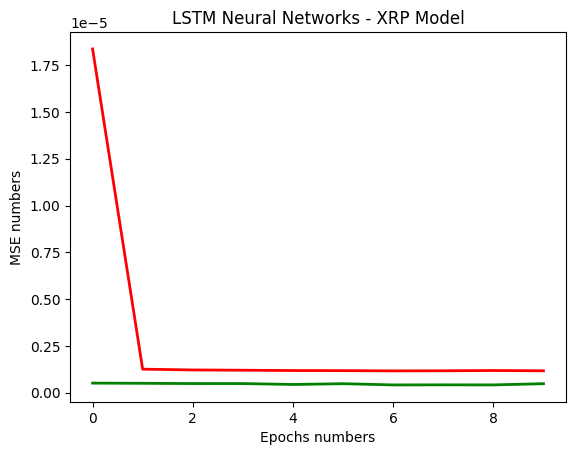

In [67]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

#### Métriques

In [68]:
# On check la différence entre les prédictions et les valeurs réelles
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

24573/24573 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step


0.0006539418567958261

In [69]:
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

9.581880663213534e-07

In [70]:
r2=r2_score(y_test, preds)
r2*100

58.46127008638998

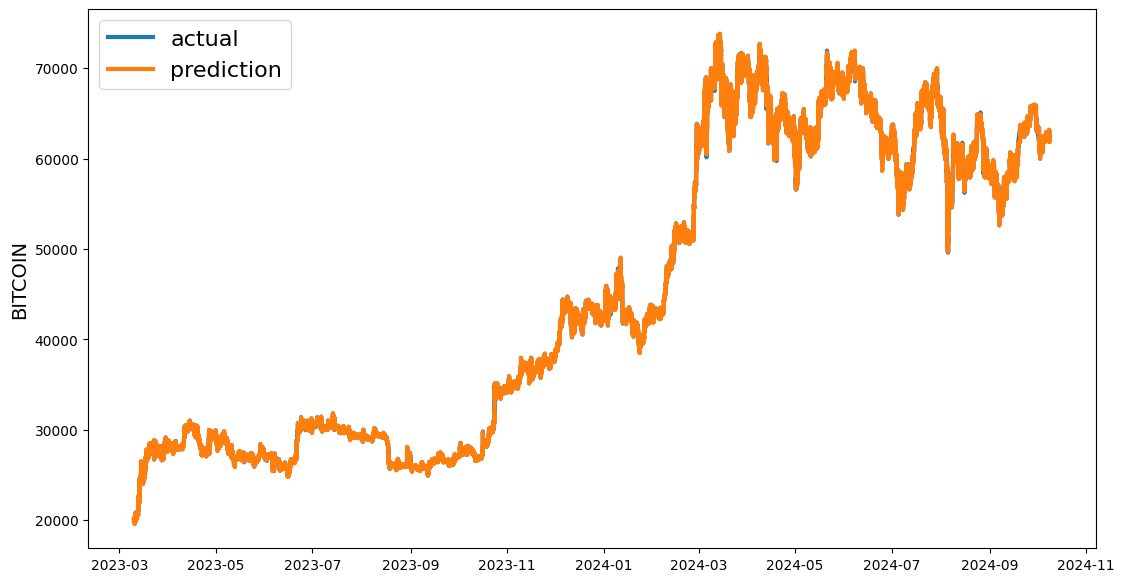

In [71]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

#### Sauvegarder le modèle

In [ ]:
model.save('lstm_model.keras')

#### Code pour faire une prédiction

In [7]:
from tensorflow.keras.models import load_model # type: ignore
import pandas as pd

data = pd.read_csv("../myhadoop/data.csv")
data = data.loc[:,['Timestamp','Open','High','Low','Close','Volume']]
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')

In [8]:
def normalise_zero_base(series):
    return series / series.iloc[0] - 1

In [18]:
features = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

last_window = data[data.index >= (pd.to_datetime('today') - pd.DateOffset(months=1))]
window_len = 5

normalized_window = last_window.apply(normalise_zero_base)

input_data = normalized_window.values[-window_len:]
num_features = input_data.shape[1]
input_data = input_data.reshape((1, window_len, num_features))

model = load_model('lstm_model.keras')
prediction = model.predict(input_data)

last_price = last_window['Close'].iloc[0]
predicted_price = (prediction[0][0] + 1) * last_price

conversion_rate = 1 / 1.09
predicted_price_eur = predicted_price * conversion_rate

print(f"La prochaine valeur prédite de 'Close' en EUR est : {predicted_price_eur}")

c:\wamp64\www\IPSSI\MIA 2\BigData\TpGroupe\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
La prochaine valeur prédite de 'Close' en EUR est : 56513.46129842034
